# Testing implementation
As the present implementation includes an own simulator, circuit class and sampler, we should verify that these code components all work properly by comparing to earlier results done with the help of the `PECOS` library: https://github.com/dpwinter/PECOS_WS_solutions/blob/main/subset_sampling.ipynb

In [1]:
import sampler
from circuit import Circuit
import numpy as np
import matplotlib.pyplot as plt
import calc

First, create the GHZ preparation circuit that was used in all cells in the reference.

In [2]:
ghz = Circuit()
ghz.append(('h', 0))
ghz.append(('cnot', (0,1)))
ghz.append(('cnot', (1,2)))
ghz.append(('cnot', (2,3)))
ghz.append(('cnot', (3,4)))
ghz.append(('cnot', (0,4)))
ghz.append(('measure', 4))
print(ghz)

0: ('h', 0)
1: ('cnot', (0, 1))
2: ('cnot', (1, 2))
3: ('cnot', (2, 3))
4: ('cnot', (3, 4))
5: ('cnot', (0, 4))
6: ('measure', 4)


Now, run a simple direct MC run with the same parameters.

CPU times: user 17.9 s, sys: 0 ns, total: 17.9 s
Wall time: 17.9 s


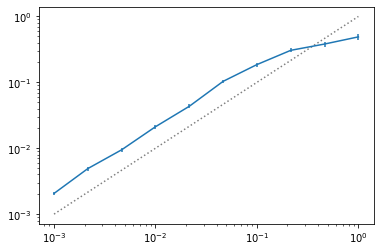

In [13]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 100
sample_range = np.int_(n_samples / p_phys)
p_Ls = []
stds = []

for p,n in zip(p_phys,sample_range):  
    err_dict = {'p': p}
    ds = sampler.DirectSampler(ghz, err_dict)
    p_L, std = ds.run(n, var=calc.Wald_var)
    p_Ls.append(p_L)
    stds.append(std)

p_Ls = np.array(p_Ls).flatten()
stds = np.array(stds).flatten()
plt.xscale('log')
plt.yscale('log')
plt.errorbar(p_phys, p_Ls, yerr=stds)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

This looks like we are getting the threshold at the same position, but the logical error rates below threshold are overall smaller than in the reference! Let's check how subset sampling performs.

[(0,), (1,), (2,)]
[(0,), (1,)]


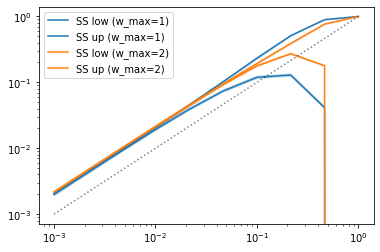

In [12]:
n_samples = 1000
p_phys = np.logspace(-3,0,10)

err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
print(ss._find_weights(p_max=[0.1], delta_max=[0.1])) # weight cutoff 2
print(ss._find_weights(p_max=[0.1], delta_max=[0.2])) # weight cutoff 1

for p_max,d_max,col,w_max in zip([0.1,0.1], [0.2,0.1], ['tab:blue', 'tab:orange'],[1,2]):
    p_L_up, p_L_low, std = ss.run(p_max=[p_max], delta_max=[d_max], n_samples=n_samples, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)
    plt.plot(p_phys, p_L_low, label="SS low (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2, color=col)
    plt.plot(p_phys, p_L_up, label="SS up (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2, color=col)
    plt.xscale('log')
    plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)
plt.legend()

Here, we again see a difference in results to the reference done in PECOS. We also see a mismatch in the interval p_phys=\[$10^{-1}$,$10^0$\] Let's plot them together.

CPU times: user 18.4 s, sys: 3.77 ms, total: 18.4 s
Wall time: 18.4 s


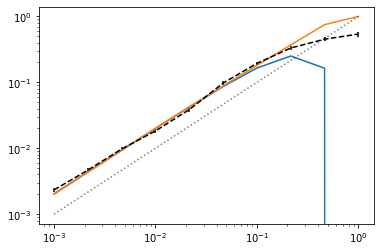

In [6]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 100
sample_range = np.int_(n_samples / p_phys)
p_Ls = []
stds = []

for p,n in zip(p_phys,sample_range):  
    err_dict = {'p': p}
    ds = sampler.DirectSampler(ghz, err_dict)
    p_L, std = ds.run(n, var=calc.Wald_var)
    p_Ls.append(p_L)
    stds.append(std)
p_Ls = np.array(p_Ls).flatten()
stds = np.array(stds).flatten()
    
err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
p_L_up, p_L_low, std = ss.run(p_max=[0.1], delta_max=[0.1], n_samples=1000, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)

plt.errorbar(p_phys, p_Ls, fmt='--', c="black", yerr=stds)
plt.plot(p_phys, p_L_low)
plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p_phys, p_L_up)
plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

However, since the direct and subset sampler agree very well, we see again that the error must be systematic in either PECOS's simulator or our own. Let's check out the other functions.

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


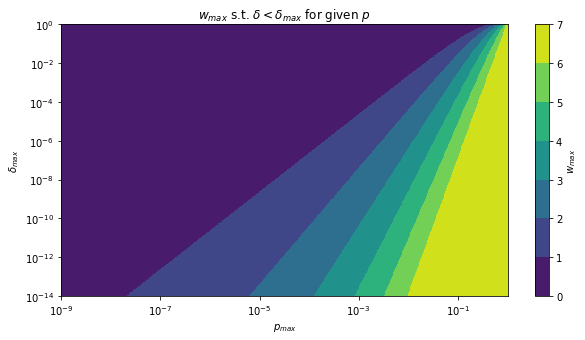

In [7]:
%time

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc.weight_cutoff(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

The $w_{max}$ selector is identical to the procedure used in the reference. Next, we check multi-parameter noise models.

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
CPU times: user 5.85 s, sys: 23.7 ms, total: 5.87 s
Wall time: 5.83 s


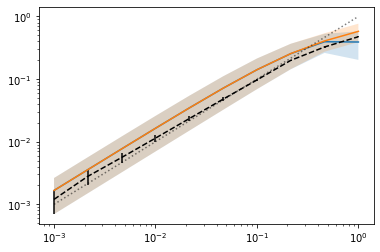

In [5]:
%%time

p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_dict = {'p1': p1, 'p2': p2}

ds = sampler.DirectSampler(ghz, err_dict)
p_L, std_ss = ds.run(n_samples=5000, var=calc.Wald_var)
    
ss = sampler.SubsetSampler(ghz, err_dict)
print(ss._find_weights(p_max=[0.5,0.5], delta_max=[0.1,0.5])) # weight cutoff
p_L_up, p_L_low, std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=20, var=calc.Wilson_var, SS_sel_fn=calc.balanced_SS_selector)

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std_ss)

plt.plot(p1, p_L_low)
plt.fill_between(p1, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p1, p_L_up)
plt.fill_between(p1, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p1, p1, 'k:', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

Again, we see systematic underestimation in comparison to the reference. The only implementation difference which could cause such a systematic offset must be introduced by using a different simulator. Let's only change the simulator component to figure out what's going on with this systematic error by plotting the results using PECOS's `SparseSim` vs. using our own `StabSim`

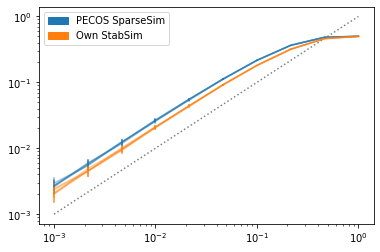

In [3]:
import pecos as pc
import simulator

ghz = Circuit([])
ghz.append(('H', 0))
ghz.append(('CNOT', (0,1)))
ghz.append(('CNOT', (1,2)))
ghz.append(('CNOT', (2,3)))
ghz.append(('CNOT', (3,4)))
ghz.append(('CNOT', (0,4)))
ghz.append(('measure Z', 4))

p_phys = np.logspace(-3,0,10)
err_dict = {'p': p_phys}
n_samples = 100000
n_reps = 5

### PECOS SIMULATOR

class DirectSamplerDiagnostic(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim.run_gate(sub_tick[0], {sub_tick[1]})
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim.run_gate(tick[0], {tick[1]})
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim.run_gate(sub_err_tick[0], {sub_err_tick[1]})
                    elif type(err_tick) == tuple:
                        sim.run_gate(err_tick[0], {err_tick[1]})
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = pc.simulators.SparseSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

for _ in range(n_reps):
    ds = DirectSamplerDiagnostic(ghz, err_dict)
    p_L, std = ds.run(n_samples=n_samples, var=calc.Wilson_var)
    plt.errorbar(p_phys, p_L, yerr=std, alpha=0.4, color='tab:blue')

### OWN SIMULATOR

ghz[-1] = ('measure', 4) # Need to redefine measure Z -> measure

class DirectSamplerDiagnostic2(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim._apply_gate(sub_tick[0], sub_tick[1])
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim._apply_gate(tick[0], tick[1])
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim._apply_gate(sub_err_tick[0], sub_err_tick[1])
                    elif type(err_tick) == tuple:
                        sim._apply_gate(err_tick[0], err_tick[1])
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = simulator.StabSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

for _ in range(n_reps):
    ds = DirectSamplerDiagnostic2(ghz, err_dict)
    p_L, std = ds.run(n_samples=n_samples, var=calc.Wilson_var)
    plt.errorbar(p_phys, p_L, yerr=std, alpha=0.4, color='tab:orange')
    
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);

import matplotlib.patches as mpatches
l1 = mpatches.Patch(color='tab:blue', label='PECOS SparseSim')
l2 = mpatches.Patch(color='tab:orange', label='Own StabSim')
plt.legend(handles=[l1,l2]);

Here we can clearly see the difference between our own `StabSim` and PECOS's `SparseSim`. To see that `StabSim` always underestimates the error rate we repeated the sampling for n_rep times. Our implementation of StabSim is based on the implementation by Strilanc (https://github.com/Strilanc/python-chp-stabilizer-simulator), which is well-tested, close to the original paper and also used in other projects. In the PECOS package however are not direct logic tests of the simulator plus the Ciaran's implementation is more opaque and not so easy to understand. To tell from which fact the difference comes needs further inspection of both simulators. (Although I am pretty confident that `StabSim`'s performance is logically sound). Let's see what the ProjectQ simulator produces (PECOS luckily provides bindings for it)

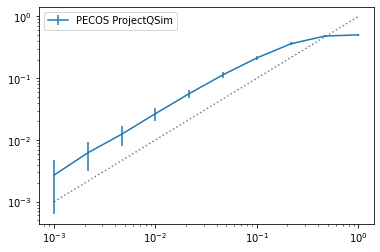

In [4]:
import pecos as pc

ghz = Circuit([])
ghz.append(('H', 0))
ghz.append(('CNOT', (0,1)))
ghz.append(('CNOT', (1,2)))
ghz.append(('CNOT', (2,3)))
ghz.append(('CNOT', (3,4)))
ghz.append(('CNOT', (0,4)))
ghz.append(('measure Z', 4))

p_phys = np.logspace(-3,0,10)
err_dict = {'p': p_phys}
n_samples = 10000

class DirectSamplerDiagnostic(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim.run_gate(sub_tick[0], {sub_tick[1]})
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim.run_gate(tick[0], {tick[1]})
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim.run_gate(sub_err_tick[0], {sub_err_tick[1]})
                    elif type(err_tick) == tuple:
                        sim.run_gate(err_tick[0], {err_tick[1]})
        return msmts
    
    def run(self, n_samples=100, var=calc.Wilson_var, sim=pc.simulators.SparseSim):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0])) # one fail counter per p_phys

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(self.err_gen, p_phys, sim)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std 

                        
    def _sample(self, err_gen=None, p_phys=None, sim=None):
        sim = sim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

ds = DirectSamplerDiagnostic(ghz, err_dict)
p_L_stvec, std_stvec = ds.run(n_samples=n_samples, var=calc.Wilson_var, sim=pc.simulators.ProjectQSim)

plt.errorbar(p_phys, p_L_stvec, yerr=std_stvec, label='PECOS ProjectQSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

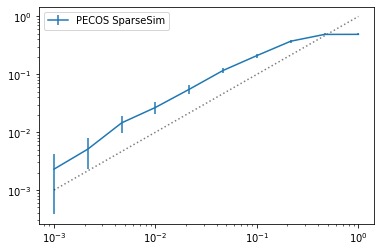

In [5]:
ds = DirectSamplerDiagnostic(ghz, err_dict)
p_L_spsim, std_spsim = ds.run(n_samples=n_samples, var=calc.Wilson_var, sim=pc.simulators.SparseSim)

plt.errorbar(p_phys, p_L_spsim, yerr=std_spsim, label='PECOS SparseSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

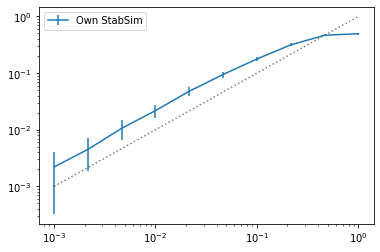

In [18]:
import simulator

class DirectSamplerDiagnostic2(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim._apply_gate(sub_tick[0], sub_tick[1])
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim._apply_gate(tick[0], tick[1])
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim._apply_gate(sub_err_tick[0], sub_err_tick[1])
                    elif type(err_tick) == tuple:
                        sim._apply_gate(err_tick[0], err_tick[1])
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = simulator.StabSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt
    
ghz[-1] = ('measure', 4)
ds = DirectSamplerDiagnostic2(ghz, err_dict)
p_L_stsim, std_stsim = ds.run(n_samples=n_samples, var=calc.Wilson_var)

plt.errorbar(p_phys, p_L_stsim, yerr=std_stsim, label='Own StabSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

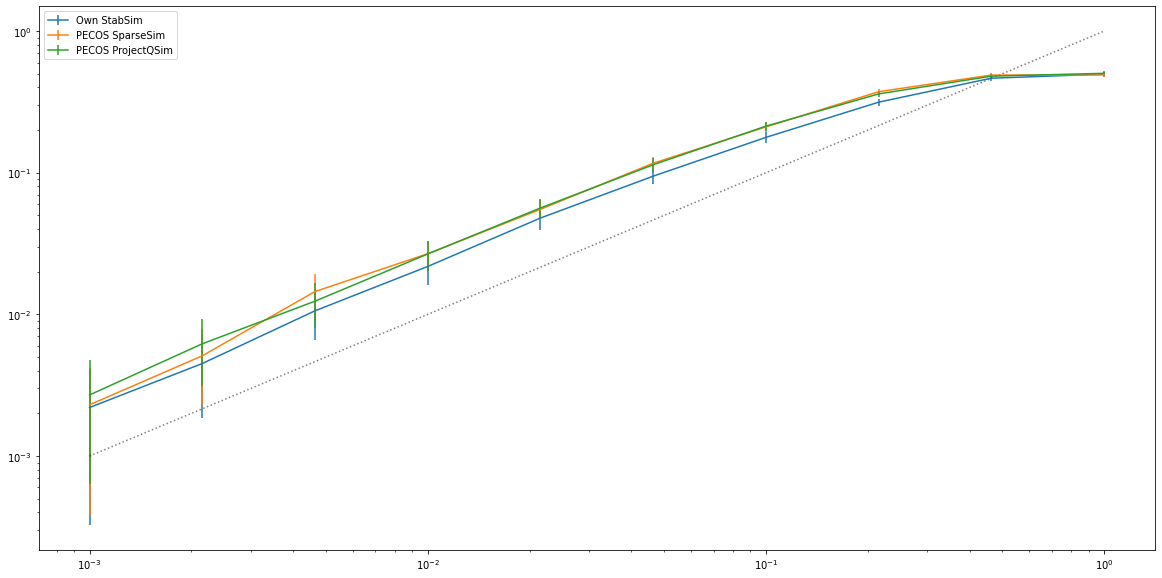

In [19]:
plt.figure(figsize=(20,10))
plt.errorbar(p_phys, p_L_stsim, yerr=std_stsim, label='Own StabSim');
plt.errorbar(p_phys, p_L_spsim, yerr=std_spsim, label='PECOS SparseSim');
plt.errorbar(p_phys, p_L_stvec, yerr=std_stvec, label='PECOS ProjectQSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

Now we see there is something wrong with our own StabSim. PECOS's SparseSim seems to agree well with the ProjectQ state vector sim. So we need to find the bug in our implementation.

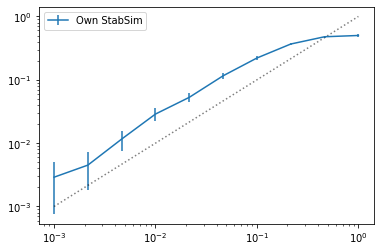

In [20]:
import random
import numpy as np

class ChpSimulator:
    """ Implementation of Aaronson/Gottesman CHP simulator.
    Updates stabilizer generators acted upon by gates of
    the Clifford group: CNOT, Hadamard and Phase (S).
    Ref: https://arxiv.org/pdf/quant-ph/0406196.pdf.
    """

    def __init__(self, n_qbs):
        self.n = n_qbs
        # tableau: X|Z, generators in rows, qubits in columns
        # Track destabilizers and stabilizers in 2*n rows
        # Destabilizers makes measurement more efficient
        self._table = np.eye(2 * n_qbs + 1, dtype=bool)
        self._x = self._table[:, :self.n]
        self._z = self._table[:, self.n:-1]
        self._r = self._table[:, -1] # track +/-1 global phase

    def cnot(self, c, t):
        self._r ^= self._x[:, c] & self._z[:, t] & (self._x[:, t] ^ self._z[:, c] ^ True)
        # 2 cases for sign flips: Y_c & Y_t and X_c & Z_t, the above is most efficient
        self._x[:, t] ^= self._x[:, c] # X propagates forward: c->t
        self._z[:, c] ^= self._z[:, t] # Z propagates backward: t->c

    def hadamard(self, i): # swap X and Z bases
        self._r ^= self._x[:, i] & self._z[:, i] # 0<->+, 1<->- no phase change
        # but +i<->-i. Thus phase change for qb on Y-axis
        # swap X-col with Z-col for a qb: 0110|1010 (column vecs)
        self._x[:, i] ^= self._z[:, i]  # 1100|1010
        self._z[:, i] ^= self._x[:, i]  # 1100|0110
        self._x[:, i] ^= self._z[:, i]  # 1010|0110

    def phase(self, i):
        # Phase gate: [[1,0],[0,i]], i.e. rotate 90 arount Z-axis
        self._r ^= self._x[:, i] & self._z[:, i]  # phase change after leaving Y-axis
        self._z[:, i] ^= self._x[:, i]  # stabilized by X or Y, not by Z.

    def measure(self, i):
        # If one generator has X in i-th column (i-th qubit) the stabilizer state
        # includes a |+> (or |+i>) for the i-th qubit. If this is the case, the state
        # must be a X or Y +1 eigenstate on this qubit, thus not in Z basis.
        # A msmt will give random outcome and thus be not deterministic.
        for p in range(self.n):
            if self._x[p+self.n, i]: # all X-ops for qubit i in stab gens (excl. destabs)
                return self._measure_random(i, p) # p: destab corresp. to 1st gen w X in i-th row
        return self._measure_determined(i) # no X's found in i-th row of stab gens

    def _measure_random(self, i, p, bias = 0.5): # p: index of first destab
        # If i-th qubit is eigenstate of X (or Y) basis,
        # After msmt the state is projected onto Z, need to update state (gens)
        self._table[p, :] = self._table[p+self.n, :] # set destab equal to stab (proj. onto Z)
        self._table[p+self.n, :] = 0 # delete stab
        self._z[p+self.n, i] = 1 # project to Z: eigenstate of Z basis
        self._r[p+self.n] = random.random() < bias # decide randomly if + or -1 eigenstate

        # Update the other stabs and destabs that have x in i-th row
        # those entries must become either I or Z (not X), since the stab state is in
        # Z-basis for this qubit. This we accomplish by multiplying all those rows
        # with the destabilizer p. This also changes the signs correctly.
        for j in range(2*self.n): 
            if self._x[j, i] and j != p and j != p+self.n:
                self._row_mult(i, p) 
        return MeasureResult(value=self._r[p+self.n], determined=False)

    def _measure_determined(self, i):
        self._table[-1, :] = 0 # set scratch space to 0
        for j in range(self.n): # go through destabilizer rows
            if self._x[j, i]:   # for each destab that is X at i-th position
                self._row_mult(-1, j + self.n) # multiply scratch row with corresponding stab
        return MeasureResult(value=self._r[-1], determined=True) # r[-1] gives msmt result

    def _row_product_sign(self, i, k):
        # 2*r_h + 2*r_i + sum(g(x1,x2,z1,z2)) == 0 or 2 (mod 4)
        # Find +1 = 0 (mod 4) or -1 = 2 (mod 4) sign of row multiplication
        # 3 parts: sign of stab 1 (r_h), sign of stab 2 (r_i) and 
        # sign of individual pauli-products in tensor product. This can only
        # be +/-1 because any imaginary unit from Pauli product will vanish, as
        # all stabilizers commute: we always have an even number of i's
        pauli_phases = sum( pauli_product_phase(self._x[i,j], self._z[i,j], 
            self._x[k,j], self._z[k,j]) for j in range(self.n) )
        p = (pauli_phases >> 1) & 1
        return bool(self._r[i] ^ self._r[k] ^ p)

    def _row_mult(self, i, k):
        # 1. Get sign of multiplication by only looking at r
        self._r[i] = self._row_product_sign(i,k)
        # 2. Do XOR operation between X and Z separately, ignoring signs
        self._x[i, :self.n] ^= self._x[k, :self.n]
        self._z[i, :self.n] ^= self._z[k, :self.n]

    def __str__(self):
        _cell = lambda row, col: ['.','X','Z','Y'][int(self._x[row,col])+2*int(self._z[row,col])]
        _row = lambda row: ('-' if self._r[row] else '+') +''.join([str(_cell(row, col)) for col in range(self.n)])
        z_obs = [_row(row) for row in range(self.n)]
        sep = ['-' * (self.n + 1)]
        x_obs = [_row(row) for row in range(self.n, 2*self.n)]
        return '\n'.join(z_obs + sep + x_obs)

def pauli_product_phase(x1, z1, x2, z2):
    """Determine power of i in product of two Paulis (X|Z)
    Returns: (0,-1,+1) for (1,-i,+i)
    Cases:  0: PP=I, IP=P, PI=P (P=any Pauli)
           +1: XY=iZ, YZ=iX, ZY=iX
           -1: XZ=-iY, YX=-iZ, ZX=-iY
    """
    
    if x1 and z1: return int(z2) - int(x2) # YZ, YX, YI
    elif x1: return z2 and 2 * int(x2) - 1 # XZ, XY, XI
    elif z1: return x2 and 1 - 2 * int(z2) # ZX, ZY, ZI
    else: return 0 # PP, IP

class MeasureResult:
    def __init__(self, value, determined):
        self.value = bool(value)
        self.determined = bool(determined)

    def __bool__(self):
        return self.value

    def __eq__(self, other):
        if isinstance(other, (bool, int)):
            return self.value == other
        if isinstance(other, MeasureResult):
            return self.value == other.value and self.determined == other.determined
        return NotImplemented

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return '{} ({})'.format(int(self.value), ['random', 'determined'][self.determined])

class StabSim(ChpSimulator):
    '''Wrapper class for ChpSim, implements useful gates.'''

    def h(self, i):
        self.hadamard(i)

    def z(self, i):
        self.phase(i)
        self.phase(i)

    def x(self, i):
        self.h(i)
        self.z(i)
        self.h(i)

    # def y(self, i):   ### THIS WAS THE BUT
    #     self.h(i)
    #     self.phase(i)
    #     self.h(i)

    def phase_adjoint(self, i):
        self.phase(i)
        self.phase(i)
        self.phase(i)

    def y(self, i):   ### THIS NEW DEFINITION GIVES THE TRUE Y-GATE!
        self.phase_adjoint(i)
        self.x(i)
        self.phase(i)

    def _apply_gate(self, sym, qbs):
        gate = getattr(self, sym.lower())
        args = (qbs,) if type(qbs)==int else qbs
        return gate(*args)

    def run(self, circuit, err_circuit=None):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = self._apply_gate(*sub_tick)
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = self._apply_gate(*tick)
                if res: 
                    msmts.append((tick_idx,res))
            
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            self._apply_gate(*sub_err_tick)
                    elif type(err_tick) == tuple:
                        self._apply_gate(*err_tick)
        return msmts

class DirectSamplerDiagnostic2(sampler.DirectSampler):
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim._apply_gate(sub_tick[0], sub_tick[1])
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim._apply_gate(tick[0], tick[1])
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim._apply_gate(sub_err_tick[0], sub_err_tick[1])
                    elif type(err_tick) == tuple:
                        sim._apply_gate(err_tick[0], err_tick[1])
        return msmts
                        
    def _sample(self, err_gen=None, p_phys=None):
        sim = StabSim(self.n_qubits)
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt
    
ghz[-1] = ('measure', 4)
ds = DirectSamplerDiagnostic2(ghz, err_dict)
p_L_stsim, std_stsim = ds.run(n_samples=n_samples, var=calc.Wilson_var)

plt.errorbar(p_phys, p_L_stsim, yerr=std_stsim, label='Own StabSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

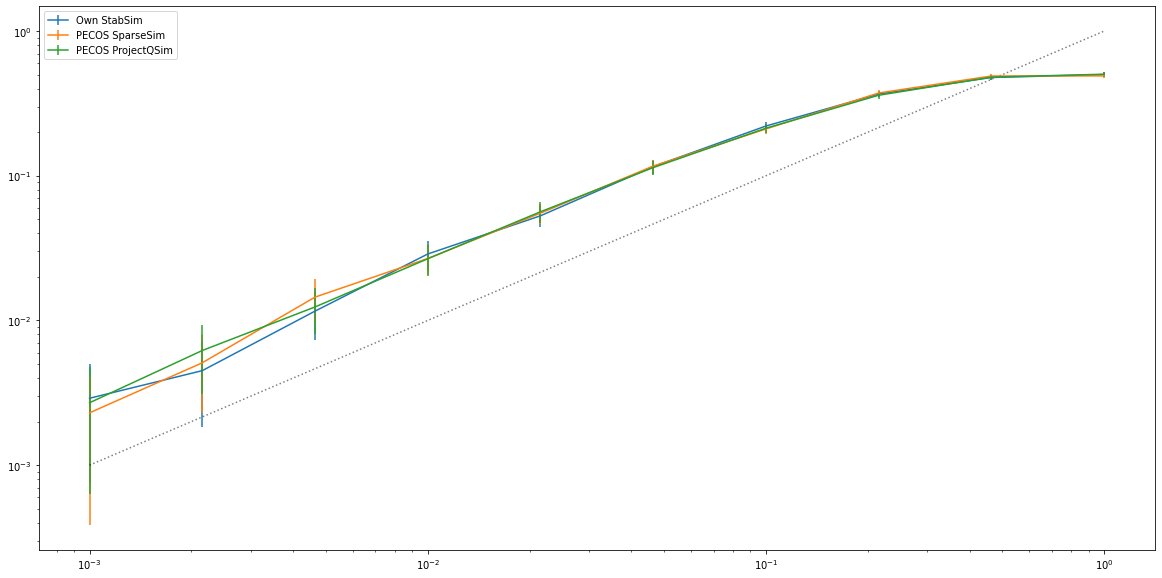

In [21]:
plt.figure(figsize=(20,10))
plt.errorbar(p_phys, p_L_stsim, yerr=std_stsim, label='Own StabSim');
plt.errorbar(p_phys, p_L_spsim, yerr=std_spsim, label='PECOS SparseSim');
plt.errorbar(p_phys, p_L_stvec, yerr=std_stvec, label='PECOS ProjectQSim');
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

Bug detected in definition of Y-gate! Fixed, now our simulator agrees reasonably well with the other two!